In [1]:
#importing the required stuff
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import csv
import yfinance as yf
import pandas_datareader.data as web
import scipy.optimize as optimization

In [2]:
%matplotlib inline

In [31]:
#MPT CODE to benchmark

In [32]:
NUM_TRADING_DAYS = 252 #252*5 cosnidered previously
NUM_PORTFOLIOS = 10000
stocks = ["JPM", "GS", "MSFT", "WMT"]

In [33]:
start_date = '2011-01-01' # YY/MM/DD
end_date = '2015-12-31'   # YY/MM/DD

In [34]:
def download_data():
    stocks_data = yf.download(stocks, start = '2011-1-1', end = '2015-12-31')['Adj Close']
    # stocks_data.head()
    return pd.DataFrame(stocks_data)

In [35]:
def show_data(data):
    data.plot(figsize=(8, 5))
    plt.show()

# show_data(data)

In [36]:
def calculate_return(data):
    log_return = np.log(data / data.shift(1))
    return log_return[1:]

In [37]:
def show_statistics(returns):
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

In [38]:
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print('Expected portfolio mean: ', portfolio_return)
    print('Expected portfolio volatility: ', portfolio_volatility)
    print("sharpe ratio of a portfolio is ", portfolio_return/portfolio_volatility)

In [39]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(8, 5))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [40]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

In [41]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [42]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))

    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])


In [43]:
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

In [44]:
def optimize_portfolio(weights, returns):
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP',
                                 bounds=bounds, constraints=constraints)

In [45]:
def print_optimal_portfolio(optimum, returns):
    print('Optimal Portfolio: ', optimum['x'].round(3))
    print('Expected return, volatility and sharpe ratio: ', statistics(optimum['x'].round(3), returns))

In [46]:
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(8, 5))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()


In [47]:
selected_assets = [1, 0, 0, 1, 1, 0]
assets = ["AAPL", "GS", "JPM", "MSFT", "MCD", "WMT"]


selected_bitstring = [i for i, e in enumerate(selected_assets) if e == 1]
# print(selected_bitstring)
my_assets = [assets[i] for i in selected_bitstring]
print("your lucky assets are ",my_assets)

your lucky assets are  ['AAPL', 'MSFT', 'MCD']


In [48]:
selected_stocks_data = yf.download(my_assets, start = '2011-01-01', end = '2015-12-31')['Adj Close']
selected_stocks_data.head()

log_return = np.log(selected_stocks_data/selected_stocks_data.shift(1))
log_return.head()

[*********************100%***********************]  3 of 3 completed


,AAPL,MCD,MSFT
Date,,,
2010-12-31,NaN,NaN,NaN
2011-01-03,0.021499,-0.002087,0.002505
2011-01-04,0.005206,-0.030352,0.003924
2011-01-05,0.008147,0.004699,-0.003210
2011-01-06,-0.000809,-0.006045,0.028866


In [49]:
weights = np.array(np.random.random(len(my_assets)))

print('normalised weights :')
weights = weights/np.sum(weights)
print(weights)

normalised weights :
[0.51520947 0.15097344 0.33381709]


In [50]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,weights)))
    sr = ret/vol 
    return np.array(sr)
    

# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)*-1

# check allocation sums to 1
def check_sum(weights): 
    return np.sum(weights) - 1

In [51]:
# create constraint variable
cons = ({'type':'eq','fun':check_sum})

# create weight boundaries
bounds = tuple((0, 1) for stocks in range(len(my_assets)))

# initial guess
# init_guess = [0.1 for stocks in range(len(my_assets))]
init_guess = [0.3, 0.5, 0.2]
# tuple((0, 1) for stocks in range(len(my_assets)))


neg_sharpe(weights)

-0.8859756966090743

In [52]:
# from scipy.optimize import minimize
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results

     fun: -0.9762143187213373
     jac: array([ 0.00029938, -0.00019003,  0.00013513])
 message: 'Optimization terminated successfully'
    nfev: 16
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.22929076, 0.53133536, 0.23937388])

In [53]:
my_weights = np.array(opt_results.x)
my_weights = my_weights.tolist()

In [54]:
tot_weights = np.sum(my_weights)
tot_weights

1.0

In [55]:
weights_alloc = dict(zip(my_assets, my_weights))
weights_alloc

{'AAPL': 0.22929075817588646,
 'MSFT': 0.5313353604347141,
 'MCD': 0.23937388138939952}

In [56]:
my_assets

['AAPL', 'MSFT', 'MCD']

In [57]:
ret = np.sum(log_return.mean() * my_weights) * 252 # returns of a portfolio after optimum weight allocation
vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,my_weights))) # risk of a portfolio after optimum weight allocation
sharpe_ratio = ret/vol # sharpe ratio of a portfolio after optimum weight allocation
print("sharpe ratio of your porrtfolio after optimization is ", sharpe_ratio)

risk_ret_dict_of_quantum = {
    'returns' : ret*100,
    'risk' : vol*100, 
    'sharpe_ratio' : sharpe_ratio 
}

sharpe ratio of your porrtfolio after optimization is  0.909092430259798


In [58]:
risk_ret_dict_of_quantum

{'returns': 14.671275978520178,
 'risk': 16.138376572256202,
 'sharpe_ratio': 0.909092430259798}

[*********************100%***********************]  4 of 4 completed


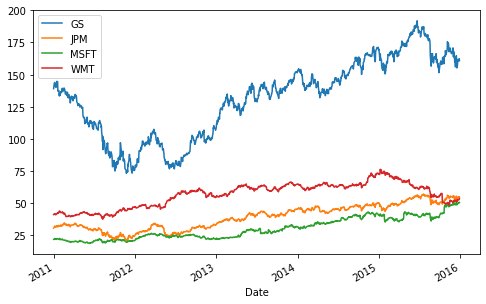

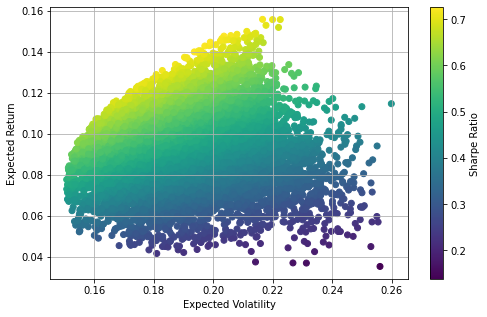

Optimal Portfolio:  [0.    0.105 0.778 0.118]
Expected return, volatility and sharpe ratio:  [0.14943091 0.20540788 0.72748379]


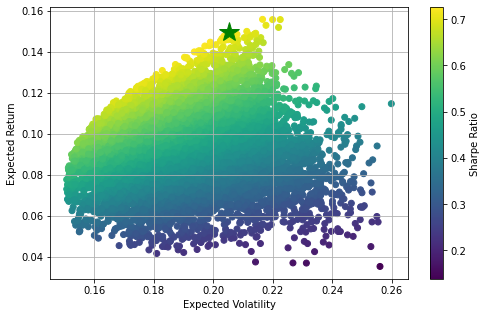

In [59]:
if __name__ == '__main__':
    # print(download_data())
    dataset = download_data()
    show_data(dataset)
    log_daily_returns = calculate_return(dataset)
    # show_statistics(log_daily_returns)
    # show_mean_variance(log_daily_returns, [0.1, 0.2, 0.3, 0.2, 0.1, 0.1])
    pweights, means, risks = generate_portfolios(log_daily_returns)
    show_portfolios(means, risks)
    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)

In [60]:
risk_ret_dict_of_quantum

{'returns': 14.671275978520178,
 'risk': 16.138376572256202,
 'sharpe_ratio': 0.909092430259798}

In [61]:
# set number of assets (= number of qubits)
#num_assets = 4
seed = 123


start = datetime.datetime(2011, 1, 1)
end = datetime.datetime(2015, 12, 31)

df = web.DataReader(["JPM", "GS", "MSFT", "WMT"],'yahoo', start, end)
df.to_csv(r'C:\Users\shrey\Documents\Qiskit\Mstockdata4_1.csv')
print (df)


import yfinance as yf
import numpy as np
selected_stocks_data = yf.download(stocks, start = '2011-01-01', end = '2015-12-31')['Adj Close']
selected_stocks_data.head()
log_return = np.log(selected_stocks_data/selected_stocks_data.shift(1))


num_assets = len(stocks)
mu = log_return.mean()*252
sigma = log_return.cov()*252
sigma = np.array(sigma)
mu = np.array(mu)

# Using data from yahoo finance
# use the name listed for particular company that you wish to add

#data = YahooDataProvider(
#        tickers=["JPM", "GS", "MSFT", "WMT"],
#        start=datetime.datetime(2011, 1, 1),
#        end=datetime.datetime(2015, 12, 31),
#    )

#data.run()

#mu = data.get_period_return_mean_vector()
#sigma = data.get_period_return_covariance_matrix()

Attributes  Adj Close                                        Close  \
Symbols           JPM          GS       MSFT        WMT        JPM   
Date                                                                 
2010-12-31  30.549223  139.064865  21.863091  41.184044  42.419998   
2011-01-03  31.384623  143.108810  21.917923  41.665138  43.580002   
2011-01-04  31.838844  143.133636  22.004097  41.825516  44.160000   
2011-01-05  32.228176  143.894424  21.933596  41.550598  44.700001   
2011-01-06  32.069546  142.414154  22.575933  41.206951  44.480000   
...               ...         ...        ...        ...        ...   
2015-12-24  54.715042  161.394363  50.051342  52.786781  66.599998   
2015-12-28  54.534313  160.642502  50.303093  52.717346  66.379997   
2015-12-29  55.101185  162.331863  50.842533  53.463631  67.070000   
2015-12-30  54.706833  160.987473  50.626743  53.524376  66.589996   
2015-12-31  54.246761  159.413071  49.880524  53.194607  66.029999   

Attributes         

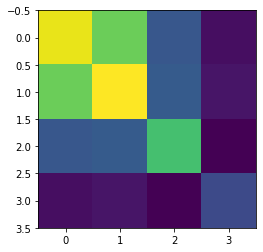

In [62]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()


In [63]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.035381186646088844*x_0^2 + 0.05930983243493784*x..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [64]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result,fname):
    
    f = open(fname, 'w')
    header = ['SELECTION', 'VALUE', 'PROBABLITY']
    writer = csv.writer(f)
    writer.writerow(header)
    
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        row = [x, value, probability]
        writer.writerow(row)
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))
    f.close()

In [65]:
%%time

#classical reference solution
#provide fname ='complete address/location of your .csv file'


exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)
fname = (r'C:\Users\shrey\Documents\Qiskit\Mstockdata4_1.csv') #change the location and nsame of .csv file

print_result(result,fname)

Optimal: selection [0. 1. 1. 0.], value -0.1911

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 1 0]	-0.1911		1.0000
 [1 1 1 1]	6.4779		0.0000
 [0 1 1 1]	1.4410		0.0000
 [1 0 1 1]	1.5254		0.0000
 [0 0 1 1]	-0.1673		0.0000
 [1 1 0 1]	1.6194		0.0000
 [0 1 0 1]	-0.1035		0.0000
 [1 0 0 1]	-0.0182		0.0000
 [0 0 0 1]	1.6030		0.0000
 [1 1 1 0]	1.5458		0.0000
 [1 0 1 0]	-0.1056		0.0000
 [0 0 1 0]	1.5016		0.0000
 [1 1 0 0]	-0.0150		0.0000
 [0 1 0 0]	1.5620		0.0000
 [1 0 0 0]	1.6484		0.0000
 [0 0 0 0]	6.5696		0.0000
CPU times: total: 250 ms
Wall time: 529 ms


    SELECTION     VALUE  PROBABLITY
0   [0 1 1 0] -0.191109         1.0
4   [0 0 1 1] -0.167320         0.0
10  [1 0 1 0] -0.105593         0.0
6   [0 1 0 1] -0.103525         0.0
7   [1 0 0 1] -0.018206         0.0
12  [1 1 0 0] -0.015038         0.0


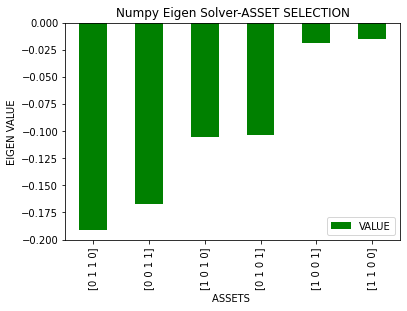

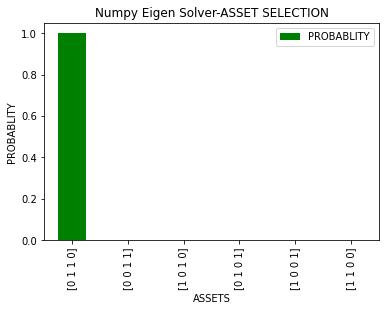

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\shrey\Documents\Qiskit\Mstockdata4_1.csv')
df = df[df['VALUE'] == df.groupby('SELECTION')['VALUE'].transform('min')]

df = df.sort_values('VALUE').drop_duplicates('SELECTION')
df1 = df[df['VALUE'] < 0]
print(df1)

df1.to_csv(r'C:\Users\shrey\Documents\Qiskit\Mstockdata4_1.csv')


ax=df1. plot(kind="bar", x = 'SELECTION', y = 'VALUE', color='green')
to=plt.title('Numpy Eigen Solver-ASSET SELECTION')
plt.setp(to, color='Black')
ax.xaxis.label.set_color('Black') 
ax.yaxis.label.set_color('Black') 
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('Black') 
ax.spines['right'].set_color('Black')
ax.spines['left'].set_color('Black')
ax.tick_params(colors='Black', which='both')
plt.ylabel('EIGEN VALUE')
plt.xlabel('ASSETS ')
#plt.figure(figsize=(10,5))
plt.show()

ax=df1. plot(kind="bar", x = 'SELECTION', y = 'PROBABLITY', color='green')
plt.ylabel('PROBABLITY')
plt.xlabel('ASSETS')
ax.xaxis.label.set_color('Black') 
ax.yaxis.label.set_color('Black') 
ax.spines['bottom'].set_color('Black')
ax.spines['top'].set_color('Black') 
ax.spines['right'].set_color('Black')
ax.spines['left'].set_color('Black')
ax.tick_params(colors='Black', which='both')

to=plt.title('Numpy Eigen Solver-ASSET SELECTION')
plt.setp(to, color='Black')

#plt.figure(figsize=(10,5))
plt.show()

In [67]:
%%time

# VQE solution
#provide fname ='complete address/location of your .csv file'


from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

#fname = (r'C:\Users\shrey\Documents\Qiskit\Mstockdata4_1.csv') #change the location and name of .csv file
print_result(result, fname)


Optimal: selection [0. 1. 1. 0.], value -0.1911

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 0 1 1]	-0.1673		0.7327
 [0 1 1 0]	-0.1911		0.2576
 [1 0 0 1]	-0.0182		0.0081
 [1 0 0 0]	1.6484		0.0004
 [1 1 0 0]	-0.0150		0.0003
 [1 1 0 1]	1.6194		0.0002
 [1 1 1 0]	1.5458		0.0002
 [0 1 0 0]	1.5620		0.0001
 [1 0 1 1]	1.5254		0.0001
 [1 0 1 0]	-0.1056		0.0001
 [0 1 0 1]	-0.1035		0.0000
 [0 0 0 1]	1.6030		0.0000
 [0 0 1 0]	1.5016		0.0000
 [0 1 1 1]	1.4410		0.0000
 [1 1 1 1]	6.4779		0.0000
 [0 0 0 0]	6.5696		0.0000
CPU times: total: 3.97 s
Wall time: 7.11 s


Circuits 

In [3]:


#VQE.construct_circuit(result, fname, operator)

NameError: name 'result' is not defined

In [31]:
from qiskit import Aer
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import X, Y, Z
from qiskit.circuit import Parameter

backend = Aer.get_backend('qasm_simulator')
hamiltonian = X ^ Y ^ Z
ansatz = EfficientSU2(3)
optimizer = SPSA()
parameters = list(ansatz.parameters)

vqe = VQE(ansatz, optimizer, quantum_instance=backend)
circuits = vqe.construct_circuit(parameters, hamiltonian)

for circuit in circuits:
    #style = {'backgroundcolor': 'lightgreen'}
    print(circuit.draw())
    #circuits.draw('mpl')

     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                                     ├»
«     │                                                                                                                                                      │»
«q_1: ┤1 EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15],θ[16],θ[17],θ[18],θ[19],θ[20],θ[21],θ[22],θ[23]) ├»
«     │                                                                                                                                                      │»
«q_2: ┤2                                                                                                                                               

In [10]:
import numpy as np
from qiskit import *
from qiskit.circuit import Gate

my_gate = Gate(name='my_gate', num_qubits=2, params=[])

In [11]:
qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.append(my_gate, [qr[0], qr[1]])
circ.append(my_gate, [qr[1], qr[2]])

circ.draw()

┌──────────┐            
q_0: ┤0         ├────────────
     │  my_gate │┌──────────┐
q_1: ┤1         ├┤0         ├
     └──────────┘│  my_gate │
q_2: ────────────┤1         ├
                 └──────────┘

In [12]:
# Build a sub-circuit
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')
sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.barrier()
sub_circ.id(sub_q[1])
sub_circ.u(1, 2, -2, sub_q[0])

# Convert to a gate and stick it into an arbitrary place in the bigger circuit
sub_inst = sub_circ.to_instruction()

qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.cx(qr[1], qr[2])
circ.append(sub_inst, [qr[1], qr[2]])

circ.draw()

┌───┐                       
q_0: ┤ H ├──■────────────────────
     └───┘┌─┴─┐     ┌───────────┐
q_1: ─────┤ X ├──■──┤0          ├
          └───┘┌─┴─┐│  sub_circ │
q_2: ──────────┤ X ├┤1          ├
               └───┘└───────────┘

In [13]:
decomposed_circ = circ.decompose() # Does not modify original circuit
decomposed_circ.draw()

┌─────────┐                                        
q_0: ┤ U2(0,π) ├──■─────────────────────────────────────
     └─────────┘┌─┴─┐     ┌───┐          ░ ┌───────────┐
q_1: ───────────┤ X ├──■──┤ H ├────■─────░─┤ U(1,2,-2) ├
                └───┘┌─┴─┐└───┘┌───┴───┐ ░ └───┬───┬───┘
q_2: ────────────────┤ X ├─────┤ Rz(1) ├─░─────┤ I ├────
                     └───┘     └───────┘ ░     └───┘

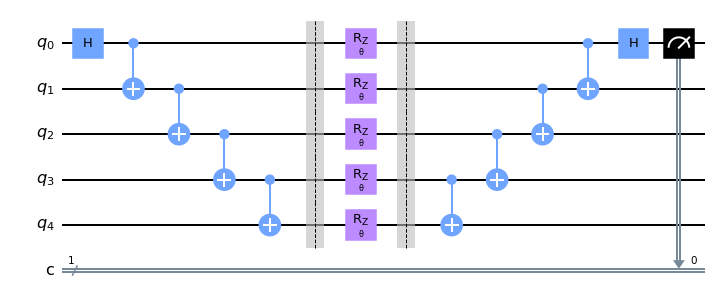

In [14]:


from qiskit.circuit import Parameter

theta = Parameter('θ')

n = 5

qc = QuantumCircuit(5, 1)

qc.h(0)
for i in range(n-1):
    qc.cx(i, i+1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier()

for i in reversed(range(n-1)):
    qc.cx(i, i+1)
qc.h(0)
qc.measure(0, 0)

qc.draw('mpl')

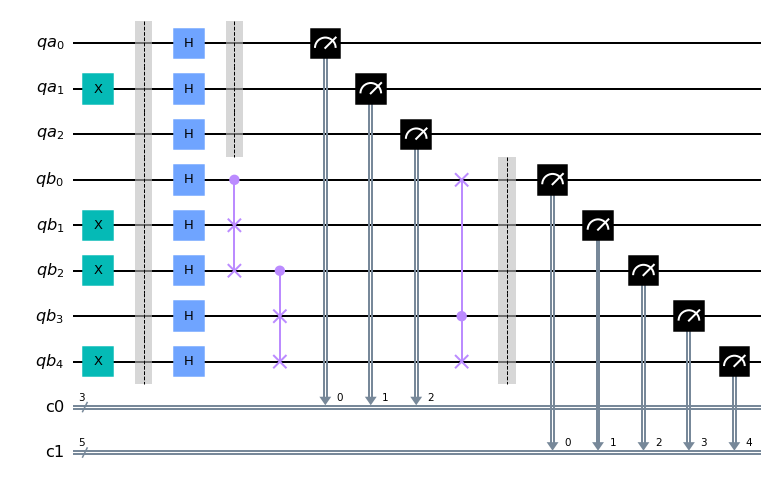

In [27]:
# Draw a new circuit with barriers and more registers

q_a = QuantumRegister(3, name='qa')
q_b = QuantumRegister(5, name='qb')
c_a = ClassicalRegister(3)
c_b = ClassicalRegister(5)

circuit = QuantumCircuit(q_a, q_b, c_a, c_b)

circuit.x(q_a[1])
circuit.x(q_b[1])
circuit.x(q_b[2])
circuit.x(q_b[4])
circuit.barrier()
circuit.h(q_a)
circuit.barrier(q_a)
circuit.h(q_b)
circuit.cswap(q_b[0], q_b[1], q_b[2])
circuit.cswap(q_b[2], q_b[3], q_b[4])
circuit.cswap(q_b[3], q_b[4], q_b[0])
circuit.barrier(q_b)
circuit.measure(q_a, c_a)
circuit.measure(q_b, c_b);

# Draw the circuit
circuit.draw(output='mpl')

In [ ]:
pip install pylatexenc


     -------------------------------------- 162.6/162.6 KB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for pylatexenc, since package 'wheel' is not installed.
  Running setup.py install for pylatexenc: started
  Running setup.py install for pylatexenc: finished with status 'done'


You should consider upgrading via the 'c:\Users\shrey\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [6]:
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import Z, I

num_qubits = 4
hamiltonian = (Z ^ Z) ^ (I ^ (num_qubits - 2))

target_energy = -1

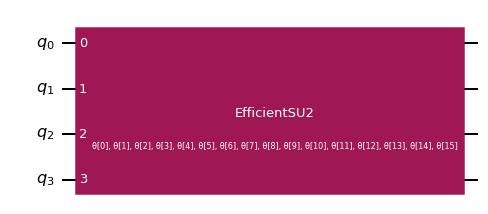

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(num_qubits, reps=1, entanglement="linear", insert_barriers=True)
ansatz.draw("mpl", style="iqx")

In [ ]:
import numpy as np
np.random.seed(999999)
target_distr = np.random.rand(2)
# We now convert the random vector into a valid probability vector
target_distr /= sum(target_distr)

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    qc.u3(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc


In [ ]:
from qiskit import Aer, transpile, assemble
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(1 - output_distr[0])
    return output_distr

def objective_function(params):
    # Obtain a quantum circuit instance from the parameters
    qc = get_var_form(params)
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    t_qc = transpile(qc, backend)
    qobj = assemble(t_qc, shots=NUM_SHOTS)
    result = backend.run(qobj).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.abs(output_distr[i] - target_distr[i]) for i in range(2)])
    return cost


In [ ]:
from qiskit.algorithms.optimizers import COBYLA

#optimizer = COBYLA()

In [ ]:
#from qiskit.aqua.components.optimizers import COBYLA

# Initialize the COBYLA optimizer

cobyla = COBYLA()
optimizer = cobyla(maxiter=500, tol=0.0001)
#optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
params = np.random.rand(3)
ret = optimizer(num_vars=3, objective_function=objective_function, initial_point=params)

# Obtain the output distribution using the final parameters
qc = get_var_form(ret[0])
t_qc = transpile(qc, backend)
qobj = assemble(t_qc, shots=NUM_SHOTS)
counts = backend.run(qobj).result().get_counts(qc)
output_distr = get_probability_distribution(counts)

print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])


TypeError: 'COBYLA' object is not callable

In [ ]:
from qiskit.circuit.library import EfficientSU2
entanglements = ["linear", "full"]
for entanglement in entanglements:
    form = EfficientSU2(num_qubits=4, entanglement=entanglement)
    if entanglement == "linear":
        print("=============Linear Entanglement:=============")
    else:
        print("=============Full Entanglement:=============")
    # We initialize all parameters to 0 for this demonstration

    #ansatz = EfficientSU2(num_qubits, reps=1, entanglement="linear", insert_barriers=True)
    #ansatz.draw("mpl", style="iqx")
    display(form.draw(fold=100))
    print()

#ansatz = EfficientSU2(num_qubits, reps=1, entanglement="linear", insert_barriers=True)
#ansatz.draw("mpl", style="iqx")
    

=============Linear Entanglement:=============


»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                                                                     ├
«     │                                                                                                                                                                                                      │
«q_1: ┤1                                                                                                                                                                                                     ├
«     │  EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15],θ[16],θ[17],θ[18],θ[19],θ[20],θ[21],θ[22],θ[23],θ[24],θ[25],θ[26],θ[27],θ[28],θ[29],θ[30],θ[31]) │
«q_2: ┤2                                                                                                                                                                                                     ├
«     │                                                                                                                                                                                                      │
«q_3: ┤3                                                                                                                                                                                                     ├
«     └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘


=============Full Entanglement:=============


»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                                                                     ├
«     │                                                                                                                                                                                                      │
«q_1: ┤1                                                                                                                                                                                                     ├
«     │  EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15],θ[16],θ[17],θ[18],θ[19],θ[20],θ[21],θ[22],θ[23],θ[24],θ[25],θ[26],θ[27],θ[28],θ[29],θ[30],θ[31]) │
«q_2: ┤2                                                                                                                                                                                                     ├
«     │                                                                                                                                                                                                      │
«q_3: ┤3                                                                                                                                                                                                     ├
«     └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

    SELECTION     VALUE    PROBABLITY
0   [0 1 1 0] -0.191109  5.014977e-01
1   [0 0 1 1] -0.167321  4.984897e-01
11  [1 0 1 0] -0.105593  3.325111e-07
6   [0 1 0 1] -0.103525  8.128636e-07
2   [1 0 0 1] -0.018206  4.049974e-06
4   [1 1 0 0] -0.015038  1.374422e-06


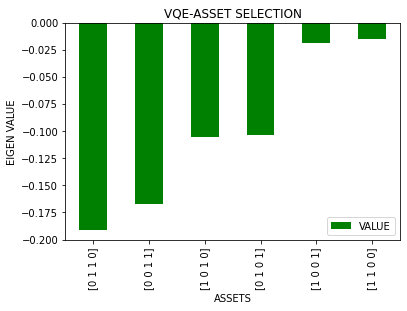

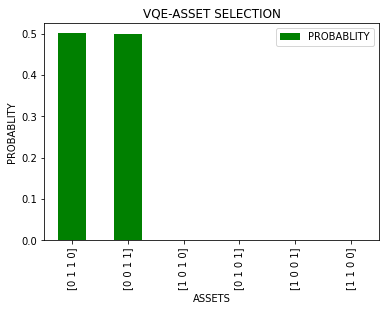

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\shrey\Documents\Qiskit\Mstockdata4_1.csv')
df = df[df['VALUE'] == df.groupby('SELECTION')['VALUE'].transform('min')]

df = df.sort_values('VALUE').drop_duplicates('SELECTION')
df1 = df[df['VALUE'] < 0]
print(df1)

df1.to_csv(r'C:\Users\shrey\Documents\Qiskit\Mstockdata4_1.csv')


ax=df1. plot(kind="bar", x = 'SELECTION', y = 'VALUE', color='green')
to=plt.title('VQE-ASSET SELECTION')
plt.setp(to, color='Black')

plt.ylabel('EIGEN VALUE')
plt.xlabel('ASSETS')
ax.xaxis.label.set_color('Black') 
ax.yaxis.label.set_color('Black') 
ax.spines['bottom'].set_color('Black')
ax.spines['top'].set_color('Black') 
ax.spines['right'].set_color('Black')
ax.spines['left'].set_color('Black')
ax.tick_params(colors='Black', which='both')
#plt.figure(figsize=(10,5))
plt.show()

ax=df1. plot(kind="bar", x = 'SELECTION', y = 'PROBABLITY', color='green')
plt.ylabel('PROBABLITY')
plt.xlabel('ASSETS')
to=plt.title('VQE-ASSET SELECTION')
plt.setp(to, color='Black')

ax.xaxis.label.set_color('Black') 
ax.yaxis.label.set_color('Black') 
ax.spines['bottom'].set_color('Black')
ax.spines['top'].set_color('Black') 
ax.spines['right'].set_color('Black')
ax.spines['left'].set_color('Black')
ax.tick_params(colors='Black', which='both')
#plt.figure(figsize=(10,5))
plt.show()

In [ ]:
%%time

# QAOA solution
#provide fname ='complete address/location of your .csv file'


algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

fname = (r'C:\Users\shrey\Documents\Qiskit\Mstockdata4_1.csv') #change the location and name of .csv file
print_result(result, fname)


Optimal: selection [0. 1. 1. 0.], value -0.1911

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0182		0.2231
 [1 1 0 0]	-0.0150		0.2033
 [0 1 0 1]	-0.1035		0.1512
 [1 0 1 0]	-0.1056		0.1436
 [0 1 1 0]	-0.1911		0.1127
 [0 0 1 1]	-0.1673		0.1065
 [1 0 0 0]	1.6484		0.0248
 [0 1 1 1]	1.4410		0.0154
 [1 0 1 1]	1.5255		0.0037
 [0 0 0 1]	1.6030		0.0035
 [1 1 1 0]	1.5458		0.0035
 [0 1 0 0]	1.5620		0.0028
 [0 0 0 0]	6.5696		0.0024
 [1 1 0 1]	1.6194		0.0017
 [1 1 1 1]	6.4779		0.0016
 [0 0 1 0]	1.5016		0.0001
CPU times: total: 5.3 s
Wall time: 6.73 s


   SELECTION     VALUE  PROBABLITY
4  [0 1 1 0] -0.191109    0.112721
5  [0 0 1 1] -0.167321    0.106469
3  [1 0 1 0] -0.105593    0.143605
2  [0 1 0 1] -0.103525    0.151238
0  [1 0 0 1] -0.018206    0.223067
1  [1 1 0 0] -0.015038    0.203281


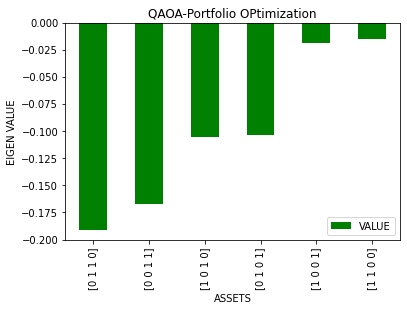

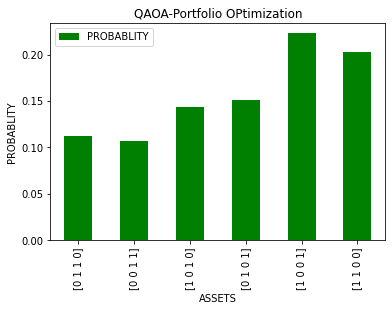

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\shrey\Documents\Qiskit\Mstockdata4_1.csv')
df = df[df['VALUE'] == df.groupby('SELECTION')['VALUE'].transform('min')]

df = df.sort_values('VALUE').drop_duplicates('SELECTION')
df1 = df[df['VALUE'] < 0]
print(df1)

df1.to_csv(r'C:\Users\shrey\Documents\Qiskit\Mstockdata4_1.csv')


ax=df1. plot(kind="bar", x = 'SELECTION', y = 'VALUE', color='green')
to=plt.title('QAOA-Portfolio OPtimization')
plt.setp(to, color='Black')

plt.ylabel('EIGEN VALUE')
plt.xlabel('ASSETS')
ax.xaxis.label.set_color('Black') 
ax.yaxis.label.set_color('Black') 
ax.spines['bottom'].set_color('Black')
ax.spines['top'].set_color('Black') 
ax.spines['right'].set_color('Black')
ax.spines['left'].set_color('Black')
ax.tick_params(colors='Black', which='both')
#plt.figure(figsize=(10,5))
plt.show()

ax=df1. plot(kind="bar", x = 'SELECTION', y = 'PROBABLITY', color='green')
plt.ylabel('PROBABLITY')
plt.xlabel('ASSETS')
to=plt.title('QAOA-Portfolio OPtimization')
plt.setp(to, color='Black')

ax.xaxis.label.set_color('Black') 
ax.yaxis.label.set_color('Black') 
ax.spines['bottom'].set_color('Black')
ax.spines['top'].set_color('Black') 
ax.spines['right'].set_color('Black')
ax.spines['left'].set_color('Black')
ax.tick_params(colors='Black', which='both')
#plt.figure(figsize=(10,5))
plt.show()

In [ ]:
#weight allocation part after asset selection using quantum

selected_assets = [1, 0, 1, 0]
assets = ["JPM", "GS", "MSFT", "WMT"]

selected_bitstring = [i for i, e in enumerate(selected_assets) if e == 1]
# print(selected_bitstring)
my_assets = [assets[i] for i in selected_bitstring]
print("your lucky assets are ",my_assets)

your lucky assets are  ['JPM', 'MSFT']


In [ ]:
import yfinance as yf
import numpy as np
selected_stocks_data = yf.download(my_assets, start = '2011-1-1', end = '2015-12-31')['Close']
selected_stocks_data.head()

[*********************100%***********************]  2 of 2 completed


,JPM,MSFT
Date,,
2010-12-31,42.419998,27.91
2011-01-03,43.580002,27.98
2011-01-04,44.160000,28.09
2011-01-05,44.700001,28.00
2011-01-06,44.480000,28.82


In [ ]:
log_return = np.log(selected_stocks_data/selected_stocks_data.shift(1))
log_return.head()

,JPM,MSFT
Date,,
2010-12-31,NaN,NaN
2011-01-03,0.026978,0.002505
2011-01-04,0.013221,0.003924
2011-01-05,0.012154,-0.003209
2011-01-06,-0.004934,0.028865


In [ ]:
import numpy as np
weights = np.array(np.random.random(len(my_assets)))

print('normalised weights :')
weights = weights/np.sum(weights)
print(weights)

normalised weights :
[0.8342273 0.1657727]


In [ ]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 250
    vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,weights)))
    sr = ret/vol 
    return np.array(sr)
    

# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)*-1

# check allocation sums to 1
def check_sum(weights): 
    return np.sum(weights) - 1

In [ ]:
# create constraint variable
cons = ({'type':'eq','fun':check_sum})

In [ ]:
# create weight boundaries
bounds = tuple((0, 1) for stocks in range(len(my_assets)))

In [ ]:
# initial guess
# init_guess = [0.1 for stocks in range(len(my_assets))]
init_guess = [0.3, 0.5]
# tuple((0, 1) for stocks in range(len(my_assets)))


In [ ]:
neg_sharpe(weights)

-0.3987866716511811

In [ ]:
#from scipy.optimize import minimize
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results

     fun: -0.5964980292579659
     jac: array([ 4.23543155e-04, -4.55901027e-05])
 message: 'Optimization terminated successfully'
    nfev: 15
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.09720525, 0.90279475])

In [ ]:
my_weights = np.array(opt_results.x)
my_weights = my_weights.tolist()

In [ ]:
tot_weights = np.sum(my_weights)
tot_weights

1.0

In [ ]:
weights_alloc = dict(zip(my_assets, my_weights))
weights_alloc

{'JPM': 0.09720525081276671, 'MSFT': 0.9027947491872333}

In [ ]:
my_assets

['JPM', 'MSFT']

In [ ]:
ret = np.sum(log_return.mean() * my_weights) * 252 # returns of a portfolio after optimum weight allocation
vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,my_weights))) # risk of a portfolio after optimum weight allocation
sharpe_ratio = ret/vol # sharpe ratio of a portfolio after optimum weight allocation
print("sharpe ratio of your porrtfolio after optimization is ", sharpe_ratio)

risk_ret_dict_of_quantum = {
    'returns' : ret*100,
    'risk' : vol*100, 
    'sharpe_ratio' : sharpe_ratio 
}

sharpe ratio of your porrtfolio after optimization is  0.7049042917474866


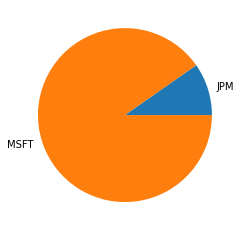

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array(my_weights)
mylabels = my_assets

plt.pie(y, labels = mylabels)
plt.show()

In [ ]:
risk_ret_dict_of_quantum

{'returns': 13.58220267163445,
 'risk': 19.268151479066205,
 'sharpe_ratio': 0.7049042917474866}

In [ ]:
!pip install pyportfolioopt

You should consider upgrading via the 'C:\Users\shrey\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [ ]:
!pip install plotly

You should consider upgrading via the 'C:\Users\shrey\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


[*********************100%***********************]  4 of 4 completed
GS      0.029782
JPM     0.123904
MSFT    0.183335
WMT     0.053947
dtype: float64


Error: rescode.err_missing_license_file(1008): License cannot be located. The default search path is ';C:\Users\shrey\mosek\mosek.lic;'.

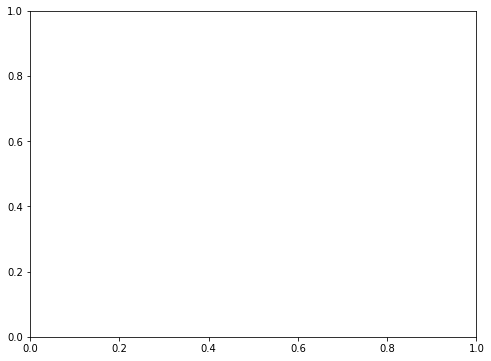

In [ ]:
stocks_df = yf.download(stocks, start = '2011-1-1', end = '2015-12-31')['Adj Close']
stocks_df.head()


# !pip install pyportfolioopt


# from pandas_datareader.data import DataReader
import yfinance as yf
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import copy
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns



mu = expected_returns.mean_historical_return(stocks_df)
S = risk_models.sample_cov(stocks_df)
print(mu)

def plot_cum_returns(data, title):    
    daily_cum_returns = 1 + data.dropna().pct_change()
    daily_cum_returns = daily_cum_returns.cumprod()*100
    fig = px.line(daily_cum_returns, title=title)
    return fig
    
fig_cum_returns = plot_cum_returns(stocks_df, 'Cumulative Returns of Individual Stocks Starting with $100')
# fig_cum_returns.show()

corr_df = stocks_df.corr().round(2) # round to 2 decimal places
fig_corr = px.imshow(corr_df, text_auto=True, title = 'Correlation between Stocks')
# fig_corr.show()

def plot_efficient_frontier_and_max_sharpe(mu, S):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S)
    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)
    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0.02)
    ret_tangent, std_tangent, _ =   ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r",     label="Max Sharpe")
# Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
# Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_efficient_frontier_and_max_sharpe(mu, S)

ef = EfficientFrontier(mu, S)
ef.max_sharpe(risk_free_rate=0.02)
weights = ef.clean_weights()
print(weights)

expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()
print('Expected annual return: {}%'.format((expected_annual_return*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio.round(2)))

: 